## Imports

In [1]:
# from class_source.idata_client import IData
from idmmonitor import IData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## API Code

In [2]:
# Variables to use
API_KEY = "58F2Z-RBUEV-6AJ4T-SL3IC"
print(API_KEY)

# initialise
idata = IData()
# echo request information on
#idata.set_verbose(True)

#Store the API Key in the package
idata.set_api_key(API_KEY)


result = idata.get_user_favorites()
if (result is None):
    print("Could not get the user datasources. Check terminal for errors.")
else:
    print(result)

print('')
print("End...")

58F2Z-RBUEV-6AJ4T-SL3IC

{'Metadata': {'Datasets': 22, 'Updated': '2021-12-30T15:46:48Z', 'TimeStamp': 2459579.1575, 'Page': 1, 'PageCount': 1, 'Rows': 22}, 'Datasets': [{'Datasource': 'ECBFX', 'Symbol': 'EURGBP', 'Name': 'ECB - Euro vs Pound Sterling', 'Description': 'European Central Bank exchange rate for Euro vs Pound Sterling (EUR/GBP)', 'Frequency': 'Day', 'Currency': None, 'Unit': None, 'Decimals': None, 'Bates': ['Close'], 'BateIndex': [0], 'StartDate': '1999-01-04', 'EndDate': '2021-12-30', 'Values': 5941, 'Corrections': 0, 'Premium': False, 'Favorite': True, 'IsCategoryDS': False, 'Subscription': 'Active', 'Logo': 'http://adm-gui.intdatamedia.com/datasources/ECBLA.png', 'Status': 200, 'Details': 'OK'}, {'Datasource': 'ECBFX', 'Symbol': 'EURCNY', 'Name': 'ECB - Euro vs Chinese yuan Renminbi', 'Description': 'European Central Bank exchange rate for Euro vs Chinese yuan Renminbi (EUR/CNY)', 'Frequency': 'Day', 'Currency': None, 'Unit': None, 'Decimals': None, 'Bates': ['Close'],

## Get_User_Favorites()

In [3]:
result_1 = idata.get_dataset_values_rc([{"Datasource":"ECBFX","Symbol":"EURGBP"}, {"Datasource":"ECBFX","Symbol":"EURUSD"}])


-----------------------------------
POST
URL: 
https://api.idatamedia.org/
API: 
GetValuesRC
Payload: 
{'SessionToken': '6f75125a052d49a822f354c30d13370b', 'Series': [{'Datasource': 'ECBFX', 'Symbol': 'EURGBP'}, {'Datasource': 'ECBFX', 'Symbol': 'EURUSD'}], 'StartDate': 'Earliest', 'EndDate': 'Latest', 'Periods': 0, 'CommonStart': 'false', 'CommonEnd': 'false', 'CommonUA': 'true', 'DateFormat': 'YYYY-MM-DD', 'DateOrder': 'asc', 'Prefill': 'false', 'Fill': 'false', 'Frequency': 'd', 'Postfill': 'false', 'Rounding': 'auto', 'ReturnMetadata': 'false', 'ReturnAccess': 'false', 'ReturnParameters': 'false'}



Functions that help ous access the data.

In [4]:
def get_daily_data(dictionary):

    columns = dictionary['Columns']
    rows = dictionary['Rows']
    corrections = dictionary['Corrections']
    df = pd.DataFrame(rows.values(), columns = [columns[0]['Name'], columns[1]['Name']], index = rows.keys())
    df = df.reset_index()
    df.rename(columns = {'index':'Date'}, inplace = True)
    df.dropna(axis = 0, inplace = True)
    df["Date"] = pd.to_datetime(df['Date'])
    df.insert(1, 'Year', df.Date.dt.year)
    df.insert(2, 'Month', df.Date.dt.month)

    return df

def get_averages(df):
    theList = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    theList_upd = {i+1:word for i,word in enumerate(theList)}

    df = df.groupby(['Year', 'Month'], as_index= False).agg({"ECB - Euro vs Pound Sterling": np.mean, "ECB - Euro vs US Dollar":np.mean})
    df['Month'] = df['Month'].replace(theList_upd)
    df.rename(columns = {"ECB - Euro vs Pound Sterling": "ECB - Euro vs Pound Sterling Mean", "ECB - Euro vs US Dollar": "ECB - Euro vs US Dollar Mean"}, inplace = True)
    return df

def get_processed(df):
    theList = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    eurgbp = df.iloc[:, :-1]
    eurusd = df.drop(columns = ['ECB - Euro vs Pound Sterling Mean'], axis = 1)
    datas = [eurgbp, eurusd]
    for num, data in enumerate(datas):    
        temp = []
        for i in range(0, len(data), 12):
            lists = data.iloc[i:i+12, -1].values.tolist()
            temp.append(lists)
        datas[num] = pd.DataFrame(temp, columns = theList, index = data.Year.unique().tolist()).round(3)
    datas = tuple(datas)
    
    return datas

Retrieving the data.


In [5]:
dataframe = get_daily_data(result_1)
dataframe.head(10)

,Date,Year,Month,ECB - Euro vs Pound Sterling,ECB - Euro vs US Dollar
0,1999-01-04,1999,1,0.71110,1.1789
1,1999-01-05,1999,1,0.71220,1.1790
2,1999-01-06,1999,1,0.70760,1.1743
3,1999-01-07,1999,1,0.70585,1.1632
4,1999-01-08,1999,1,0.70940,1.1659
7,1999-01-11,1999,1,0.70440,1.1569
8,1999-01-12,1999,1,0.70660,1.1520
9,1999-01-13,1999,1,0.70840,1.1744
10,1999-01-14,1999,1,0.70620,1.1653
11,1999-01-15,1999,1,0.70390,1.1626


The methods we will use require our data to be a Time-Series. That means the index of our Data-Frame has to be of type datetime. Also our data is recorded on bussiness days only, so we set frequency to "b", which means bussiness days.

In [6]:
dataframe["Date"] = pd.to_datetime(dataframe["Date"])
dataframe.set_index("Date", inplace=True)
dataframe = dataframe.asfreq('b')
dataframe = dataframe.fillna(method='ffill')

One of the requirements of a simple AR model is stationary data. This property is tested by the Dicky-Fuller test.

In [7]:
import statsmodels.tsa.stattools as sts 

sts.adfuller(dataframe["ECB - Euro vs Pound Sterling"])

(-1.4441103283784626,
 0.5609560708479588,
 22,
 5976,
 {'1%': -3.4314447307775278,
  '5%': -2.8620237700170423,
  '10%': -2.567027508374641},
 -48980.66727431904)

The result of test is not significant, therefore the data is not stationary. We should convert it to daily returns, that is the percentage difference between today and yesterday. 

In [8]:
dataframe['returns'] = dataframe["ECB - Euro vs Pound Sterling"].pct_change(1).mul(100)
dataframe = dataframe.iloc[1:]

sts.adfuller(dataframe["returns"])

(-16.82993026647199,
 1.1601525638464014e-29,
 21,
 5976,
 {'1%': -3.4314447307775278,
  '5%': -2.8620237700170423,
  '10%': -2.567027508374641},
 8668.56783907517)

This result is significant, therefore the data is stationary and apropriate for the AR model. We run the ACF/PCF tests to determine the significance of specific lags.

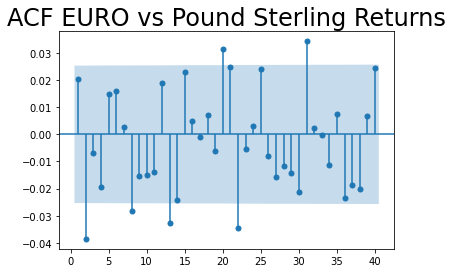

In [9]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(dataframe["returns"], lags=40, zero = False)
plt.title("ACF EURO vs Pound Sterling Returns", size=24)
plt.show()

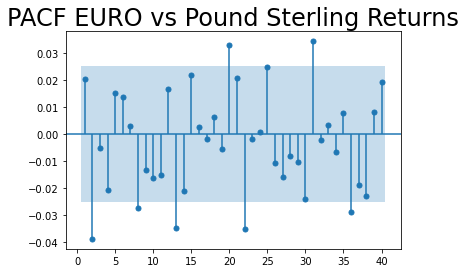

In [10]:
sgt.plot_pacf(dataframe["returns"], lags = 40, zero = False, method = ('ols'))
plt.title("PACF EURO vs Pound Sterling Returns", size=24)
plt.show()

The ACF and PACF appear very similar. This is because we are using returns, which remove the compound effects, which are normally detected by the ACF.

We also observe the first lag is not significant, but the second one is. We can also observer some lags have positive autocorrelation, while others have negative autocorrelation. All the significant lags (outside the blue area) could potentially be included in the model.

First we will start with AR(1) model meaning it has only one lag, than we will experiment by adding new lags and testing whether the model improves.

In [11]:
from statsmodels.tsa.arima_model import ARMA

model_ret_ar_1 = ARMA(dataframe["returns"], order = (1,0))
results_ret_ar_1 = model_ret_ar_1.fit()
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5998
Model:                     ARMA(1, 0)   Log Likelihood               -4357.240
Method:                       css-mle   S.D. of innovations              0.500
Date:                Thu, 30 Dec 2021   AIC                           8720.479
Time:                        19:58:35   BIC                           8740.577
Sample:                    01-05-1999   HQIC                          8727.459
                         - 12-30-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0040      0.007      0.609      0.543      -0.009       0.017
ar.L1.returns     0.0204      0.013      1.581      0.114      -0.005       0.046
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           49.0138           +0.0000j           49.0138            0.0000
-----------------------------------------------------------------------------
"""

As we see none of the coefficients are significant. We will try to find the model with the optimal lag.

The model is better if the information criteria(AIC, BIC) is decreasing and if the Log Likelihood is increasing. We define a Log-Likelihood Ratio test, which balances the trade off between the two aforementioned criteris.

In [12]:
from scipy.stats.distributions import chi2

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

The test returns a p-value. If it is lower than 0.05 the test is significant and the model is superior to previous one.

In [16]:
model_ret_ar_8 = ARMA(dataframe["returns"], order = (8,0))
results_ret_ar_8 = model_ret_ar_8.fit()
print(results_ret_ar_8.summary())
print ("LLR test: " + str(LLR_test(model_ret_ar_1, model_ret_ar_8)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5998
Model:                     ARMA(8, 0)   Log Likelihood               -4347.723
Method:                       css-mle   S.D. of innovations              0.500
Date:                Thu, 30 Dec 2021   AIC                           8715.447
Time:                        19:59:55   BIC                           8782.439
Sample:                    01-05-1999   HQIC                          8738.711
                         - 12-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0040      0.006      0.649      0.517      -0.008       0.016
ar.L1.returns     0.0210      0.013      1.630      0.103      -0.004       0.046
ar.L2.returns    -0.0390      0.013     

The model with 8 lags is superior. We can experient with different values, using the PACF as the direction.